## import

In [17]:
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.controller.trainer import MultiOutputClassificationTrainer
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.plot import plot_grids
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.semantic_segmentation.models.dual_attention import DANet
from torchlake.semantic_segmentation.models.pspnet import PSPLoss
from tqdm import tqdm

# setting

In [18]:
artifacts_path = Path("../../artifacts/dual-attention")
data_path = Path("../../data")

In [19]:
DEVICE = torch.device("cuda:0")

# data

In [20]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [21]:
preprocess = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0,1),
        ToTensorV2(),
    ]
)

In [22]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=preprocess,
)

In [23]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

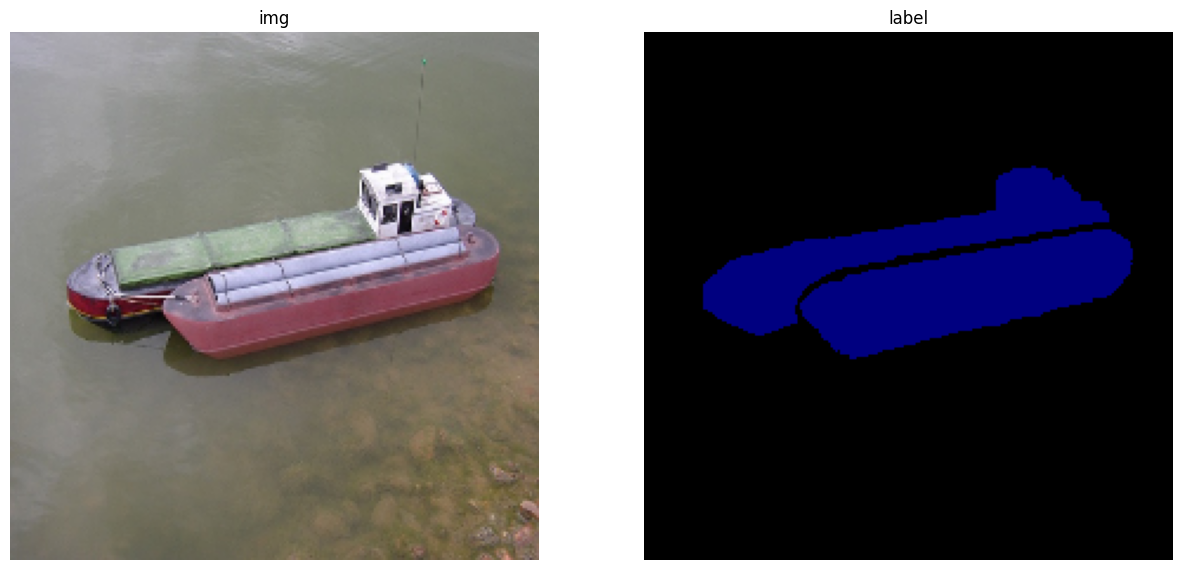

In [24]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

In [25]:
NUM_CLASS = len(VOC_CLASS_NAMES)

# model

In [26]:
model = DANet(NUM_CLASS + 1, frozen_backbone=False).to(DEVICE)
model.train()

DANet(
  (backbone): ResNetFeatureExtractor(
    (feature_extractor): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

In [27]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
DANet                                              --
├─ResNetFeatureExtractor: 1-1                      --
│    └─Sequential: 2-1                             --
│    │    └─Sequential: 3-1                        9,536
│    │    └─Sequential: 3-2                        215,808
│    │    └─Sequential: 3-3                        1,219,584
│    │    └─Sequential: 3-4                        7,098,368
│    │    └─Sequential: 3-5                        14,964,736
│    │    └─AdaptiveAvgPool2d: 3-6                 --
│    └─ImageNetNormalization: 2-2                  --
├─DualAttention2d: 1-2                             --
│    └─Sequential: 2-3                             --
│    │    └─Conv2dNormActivation: 3-7              1,179,776
│    │    └─SpatialAttention2d: 3-8                5,201
│    │    └─Conv2dNormActivation: 3-9              36,992
│    └─Sequential: 2-4                             --
│    │    └─Conv2dNormActivation:

# train

In [28]:
EPOCHS = 30

In [29]:
trainer = MultiOutputClassificationTrainer(EPOCHS, DEVICE)

In [30]:
criterion = PSPLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [31]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [32]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

100%|██████████| 91/91 [03:12<00:00,  2.12s/it]


epoch 1 : 0.043530691967724446


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


epoch 2 : 0.02389964966901711


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


epoch 3 : 0.019130853813264397


100%|██████████| 91/91 [00:49<00:00,  1.85it/s]


epoch 4 : 0.01656899872430406


100%|██████████| 91/91 [00:49<00:00,  1.84it/s]


epoch 5 : 0.01504209140254246


100%|██████████| 91/91 [00:49<00:00,  1.85it/s]


epoch 6 : 0.012979823492139905


100%|██████████| 91/91 [00:49<00:00,  1.84it/s]


epoch 7 : 0.011283598441098417


100%|██████████| 91/91 [00:50<00:00,  1.79it/s]


epoch 8 : 0.011041746935346625


100%|██████████| 91/91 [00:49<00:00,  1.85it/s]


epoch 9 : 0.010440867604012345


100%|██████████| 91/91 [00:54<00:00,  1.66it/s]


epoch 10 : 0.008897383850845661


100%|██████████| 91/91 [00:48<00:00,  1.86it/s]


epoch 11 : 0.007367735436943534


100%|██████████| 91/91 [00:47<00:00,  1.90it/s]


epoch 12 : 0.0073696666724652376


100%|██████████| 91/91 [00:48<00:00,  1.89it/s]


epoch 13 : 0.00810150777573114


100%|██████████| 91/91 [00:49<00:00,  1.84it/s]


epoch 14 : 0.007393763559246129


100%|██████████| 91/91 [00:50<00:00,  1.80it/s]


epoch 15 : 0.005939600554264181


100%|██████████| 91/91 [00:58<00:00,  1.57it/s]


epoch 16 : 0.005057436685272298


100%|██████████| 91/91 [00:50<00:00,  1.78it/s]


epoch 17 : 0.004798874990748507


100%|██████████| 91/91 [00:51<00:00,  1.77it/s]


epoch 18 : 0.004556128760328987


100%|██████████| 91/91 [00:50<00:00,  1.80it/s]


epoch 19 : 0.0044206641870294956


100%|██████████| 91/91 [00:49<00:00,  1.85it/s]


epoch 20 : 0.00430137788938297


100%|██████████| 91/91 [00:49<00:00,  1.84it/s]


epoch 21 : 0.0042121397090850625


100%|██████████| 91/91 [00:48<00:00,  1.87it/s]


epoch 22 : 0.004115777550735972


100%|██████████| 91/91 [00:48<00:00,  1.88it/s]


epoch 23 : 0.004008518864533731


100%|██████████| 91/91 [00:51<00:00,  1.76it/s]


epoch 24 : 0.0039017039663311872


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


epoch 25 : 0.0038410910190298008


100%|██████████| 91/91 [00:51<00:00,  1.78it/s]


epoch 26 : 0.003769961856100913


100%|██████████| 91/91 [00:49<00:00,  1.84it/s]


epoch 27 : 0.0036992882813357717


100%|██████████| 91/91 [00:49<00:00,  1.84it/s]


epoch 28 : 0.0036327957538990203


100%|██████████| 91/91 [00:50<00:00,  1.81it/s]


epoch 29 : 0.0035807772918225646


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]

epoch 30 : 0.003513717793624152


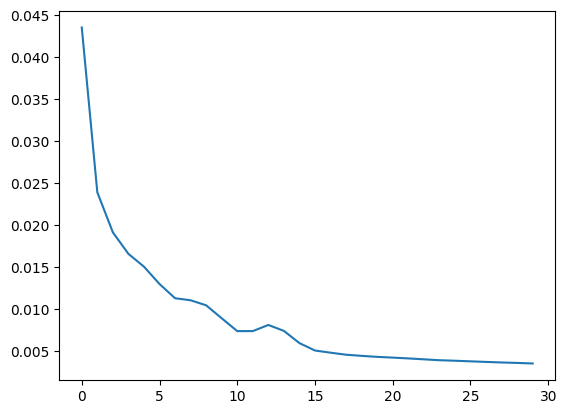

In [33]:
plt.plot(training_loss)

In [15]:
model.train()
for e in range(EPOCHS):
    running_loss = 0.0
    for img, label in tqdm(train_loader):
        optimizer.zero_grad()

        img = img.to(DEVICE)
        label = label.long().to(DEVICE)

        output = model(img)
        loss = criterion(*output, label)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"epoch {e+1}: {running_loss/len(train_dataset)}")

100%|██████████| 91/91 [01:04<00:00,  1.40it/s]


epoch 1: 0.044416351004069175


100%|██████████| 91/91 [00:34<00:00,  2.62it/s]


epoch 2: 0.023450315264627528


100%|██████████| 91/91 [00:33<00:00,  2.68it/s]


epoch 3: 0.018744576521604037


100%|██████████| 91/91 [00:33<00:00,  2.71it/s]


epoch 4: 0.016369123701127666


100%|██████████| 91/91 [00:34<00:00,  2.62it/s]


epoch 5: 0.015243912700767007


100%|██████████| 91/91 [00:34<00:00,  2.63it/s]


epoch 6: 0.013009775382646612


100%|██████████| 91/91 [00:33<00:00,  2.74it/s]


epoch 7: 0.011380467941128344


100%|██████████| 91/91 [00:33<00:00,  2.73it/s]


epoch 8: 0.010300127513785973


100%|██████████| 91/91 [00:33<00:00,  2.72it/s]


epoch 9: 0.009758390028412056


100%|██████████| 91/91 [00:33<00:00,  2.72it/s]


epoch 10: 0.009561683063117492


100%|██████████| 91/91 [00:32<00:00,  2.76it/s]


epoch 11: 0.008150375266890324


100%|██████████| 91/91 [00:33<00:00,  2.75it/s]


epoch 12: 0.007760357307356492


100%|██████████| 91/91 [00:32<00:00,  2.76it/s]


epoch 13: 0.007619354913539998


100%|██████████| 91/91 [00:33<00:00,  2.74it/s]


epoch 14: 0.008783745189691957


100%|██████████| 91/91 [00:33<00:00,  2.75it/s]


epoch 15: 0.006507344224221347


100%|██████████| 91/91 [00:32<00:00,  2.76it/s]


epoch 16: 0.006248408413776368


100%|██████████| 91/91 [00:33<00:00,  2.71it/s]


epoch 17: 0.0076186692145858645


100%|██████████| 91/91 [00:34<00:00,  2.65it/s]


epoch 18: 0.009739590640580413


100%|██████████| 91/91 [00:33<00:00,  2.69it/s]


epoch 19: 0.007313828896174839


100%|██████████| 91/91 [00:33<00:00,  2.70it/s]


epoch 20: 0.005828478769710946


100%|██████████| 91/91 [00:33<00:00,  2.69it/s]


epoch 21: 0.0060465115269884556


100%|██████████| 91/91 [00:33<00:00,  2.69it/s]


epoch 22: 0.005060752273792669


100%|██████████| 91/91 [00:32<00:00,  2.80it/s]


epoch 23: 0.004155344729095319


100%|██████████| 91/91 [00:32<00:00,  2.83it/s]


epoch 24: 0.0037010616165356583


100%|██████████| 91/91 [00:32<00:00,  2.83it/s]


epoch 25: 0.0034725695382963537


100%|██████████| 91/91 [00:32<00:00,  2.82it/s]


epoch 26: 0.003284578373699797


100%|██████████| 91/91 [00:33<00:00,  2.69it/s]


epoch 27: 0.0031391756613558196


100%|██████████| 91/91 [00:34<00:00,  2.63it/s]


epoch 28: 0.0030068401368753715


100%|██████████| 91/91 [00:33<00:00,  2.70it/s]


epoch 29: 0.0029223493328832738


100%|██████████| 91/91 [00:32<00:00,  2.83it/s]

epoch 30: 0.00278694083139817


In [42]:
model_path = artifacts_path.joinpath('danet.pth')

In [43]:
# torch.onnx.export(model, torch.randn(1, 3, 224, 224).cuda(), "fcn.onnx")
torch.save(model.state_dict(), model_path)

In [44]:
get_file_size(model_path)

'108.32MiB'

# inference

In [45]:
model.load_state_dict(torch.load(model_path), strict=False)

<All keys matched successfully>

In [46]:
# for inference, be cautious if you have not saved trained weights
if hasattr(model, "aux"):
    del model.aux

In [47]:
model_path = artifacts_path.joinpath('danet.inference.pth')

In [48]:
torch.save(model.state_dict(), model_path)

In [49]:
get_file_size(model_path)

'99.31MiB'

In [34]:
test_preprocess = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0,1),
        ToTensorV2(),
    ]
)

In [35]:
test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_preprocess,
)

In [36]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

### dice coef

In [37]:
from torchmetrics.classification import jaccard

In [38]:
metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(DEVICE)

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        labels = labels.long()
        metric.update(output, labels)

100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


In [39]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.88 
bicycle        : 0.56 
bird           : 0.93 
boat           : 0.87 
bottle         : 0.89 
bus            : 0.95 
car            : 0.9  
cat            : 0.95 
chair          : 0.75 
cow            : 0.89 
diningtable    : 0.93 
dog            : 0.9  
horse          : 0.82 
motorbike      : 0.86 
person         : 0.88 
pottedplant    : 0.67 
sheep          : 0.9  
sofa           : 0.9  
train          : 0.93 
tvmonitor      : 0.91 
----------------------
total          : 0.86 


### for image in dataset

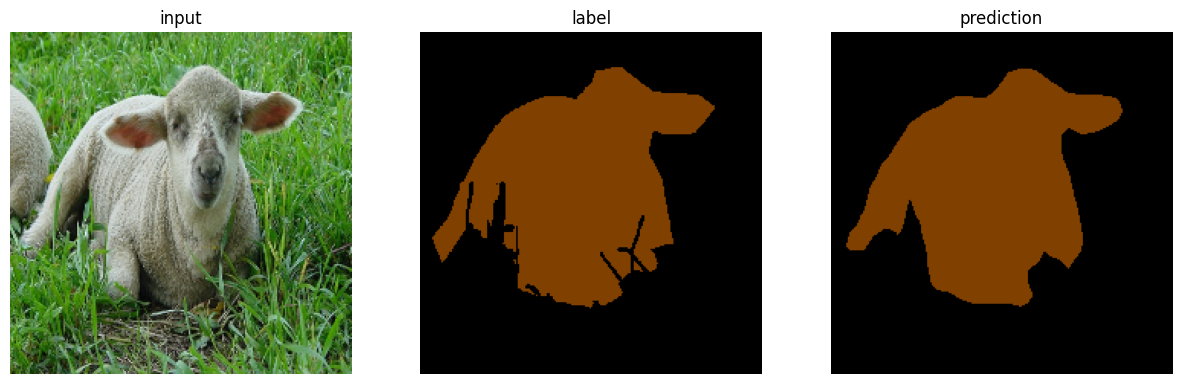

In [40]:
interest_pic = 11

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image you like

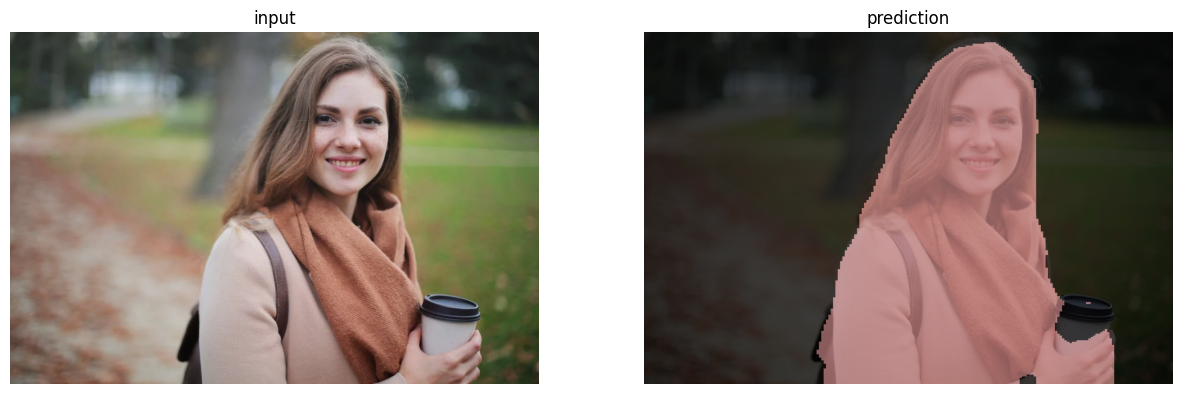

In [41]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_preprocess(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )